# 라이브러리

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, train_test_split
import glob
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, recall_score, f1_score
from sklearn.svm import SVC

# 회귀 대신 분류로

l1, l2 정규화를 이용하여 분류예측을 진행해본다

In [64]:
data_train = pd.read_csv("../model_train_data.csv")
data_test = pd.read_csv("../model_test_data.csv")

data_train["test_index"]=0
data_test["test_index"]=1
data_full = pd.concat([data_train, data_test], axis=0)

# 상영주차 분류

- 박스플롯 기준 이상치 : 장기 상영 (장기 상영한다고 흥행이라는 것은 아니다, 독립영화의 경우가 이에 포함된다.)
- 이상치가 아닌 것 중 50분위수 보다 위 : 중기 상영
- 이상치가 아닌 것 중 50분위수 보다 아래 : 단기 상영

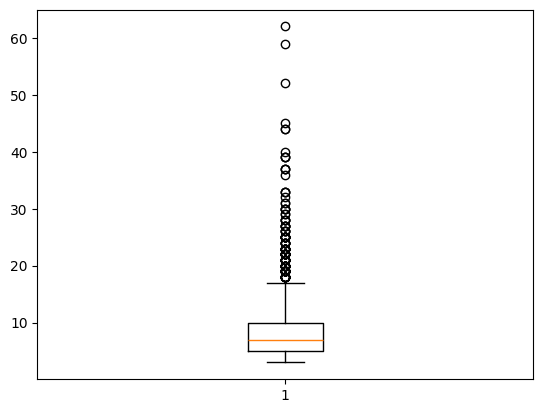

In [65]:
plt.boxplot(data_full['Total_Weeks'])
plt.show()

In [66]:
q1 = data_full["Total_Weeks"].quantile(0.25)
q3 = data_full["Total_Weeks"].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 1.5*iqr

In [67]:
data_full["Total_Weeks_Category"] = 0
data_full.loc[data_full["Total_Weeks"] > upper_bound, "Total_Weeks_Category"] = 2

In [68]:
temp = data_full[data_full["Total_Weeks"] < upper_bound].copy()

In [69]:
median_bound = np.median(temp["Total_Weeks"])

In [70]:
data_full.loc[(data_full["Total_Weeks"] >= median_bound) & (data_full["Total_Weeks"] < upper_bound), "Total_Weeks_Category"] = 1

# 학습용 데이터셋 분할

In [71]:
X = data_full.drop(columns=["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks", "Total_Weeks_Category"])
y = data_full[["test_index", "Total_Weeks_Category"]].copy()

## 범주형 변수 원핫인코딩 및 독립변수 로그변환

In [72]:
num_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols = ['Month', 'Pandemic', 'Grade', 'Main_Country']

In [73]:
log_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd']
X[log_cols] = np.log1p(X[log_cols])

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
onehot_columns = [col for col in X.columns if any(prefix in col for prefix in ['Month_', 'Pandemic_', 'Grade_', 'Main_Country_'])]
X[onehot_columns] = X[onehot_columns].astype(int)

연도 변환

In [74]:
X["Year"] = X["Year"] - X["Year"].min()

정규화

In [75]:
scaler_standard = StandardScaler()
X.loc[:, num_cols]= scaler_standard.fit_transform(X[num_cols])

C:\Users\swoo6\AppData\Local\Temp\ipykernel_15316\394874965.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.1582566   0.16640323 -1.65199462 ...  1.48887439 -0.66014125
 -1.48668572]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, num_cols]= scaler_standard.fit_transform(X[num_cols])


분할

In [76]:
X_train = X[X["test_index"]==0].copy()
X_train.drop(columns = "test_index", inplace = True)

X_test = X[X["test_index"]==1].copy()
X_test.drop(columns = "test_index", inplace = True)

y_train = y[y["test_index"]==0].copy()
y_train.drop(columns = "test_index", inplace = True)

y_test = y[y["test_index"]==1].copy()
y_test.drop(columns = "test_index", inplace = True)

In [77]:
print(list(X_train.columns))

['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25', 'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35', 'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45', 'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'e53', 'e54', 'e55', 'e56', 'e57', 'e58', 'e59', 'e60', 'e61', 'e62', 'e63', 'e64', 'e65', 'e66', 'e67', 'e68', 'e69', 'e70', 'e71', 'e72', 'e73', 'e74', 'e75', 'e76', 'e77', 'e78', 'e79', 'e80', 'e81', 'e82', 'e83', 'e84', 'e85', 'e86', 'e87', 'e88', 'e89', 'e90', 'e91', 'e92', 'e93', 'e94', 'e95', 'e96', 'e97', 'e98', 

# L1, L2 분류 모델

In [78]:
C_values = np.logspace(-3, 3, 100)
param_grid = {'C': C_values}

In [79]:
# L2 규제
ridge_base = LogisticRegression(
    penalty='l2', 
    solver='lbfgs', 
    multi_class='multinomial', 
    random_state=42, 
    max_iter=1000
)

# GridSearchCV 설정 (5-겹 교차 검증)
grid_search_ridge = GridSearchCV(
    estimator=ridge_base, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, # 가능한 모든 코어 사용
    verbose=1 # 진행 상황 출력
)

# 모델 훈련 및 최적의 C 탐색
grid_search_ridge.fit(X_train, y_train)

best_ridge_clf = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_clf.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


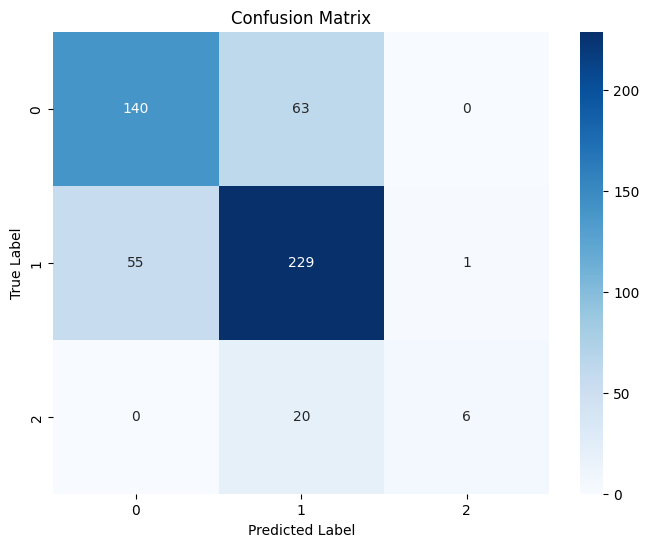

In [80]:
cm = confusion_matrix(y_test, y_pred_ridge)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [81]:
# L1 규제
lasso_base = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    multi_class='multinomial', 
    random_state=42, 
    max_iter=1000 
)

grid_search_lasso = GridSearchCV(
    estimator=lasso_base, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 모델 훈련 및 최적의 C 탐색
grid_search_lasso.fit(X_train, y_train)

# 최적 모델 추출 및 평가
best_lasso_clf = grid_search_lasso.best_estimator_
y_pred_lasso = best_lasso_clf.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


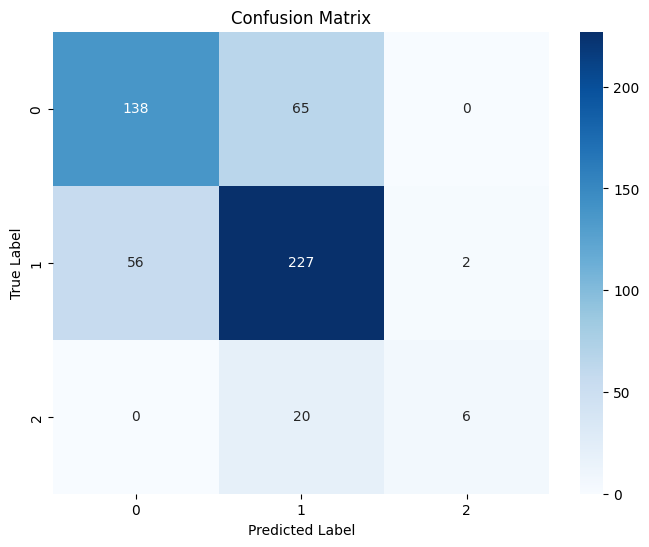

In [82]:
cm = confusion_matrix(y_test, y_pred_lasso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# SVM 적용

In [83]:
param_distributions = {
    'C': np.logspace(-3, 3, 100),
    'gamma': np.logspace(-5, 0, 100),
    'kernel': ['rbf'],
    'class_weight': ['balanced'] # 불균형 처리를 위해 'balanced'로 고정
}

In [84]:
scoring_metric = make_scorer(f1_score, average='macro')

In [86]:
from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(
    estimator=SVC(random_state=42, probability=True), 
    param_distributions=param_distributions,
    n_iter=1000,
    scoring=scoring_metric, 
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1 # 가능한 모든 CPU 코어 사용 (-1)
)

In [87]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03...
       1.74752840e-01, 1.96304065e-01, 2.20513074e-01, 2.47707636e-01,
       2.78255940e-01, 3.12571585e-01, 3.51119173e-01, 3.94420606e-01,
       4.43062146e-01, 4.97702356e-01, 5.59081018e-01, 6.28029144e-01,
       7.05480231e-01, 7.92482898e-01, 8.90215085e-01, 1.00000000e+00]),
                                        'kernel': ['rbf']},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=1)

In [88]:
best_svc = random_search.best_estimator_
y_pred = best_svc.predict(X_test)

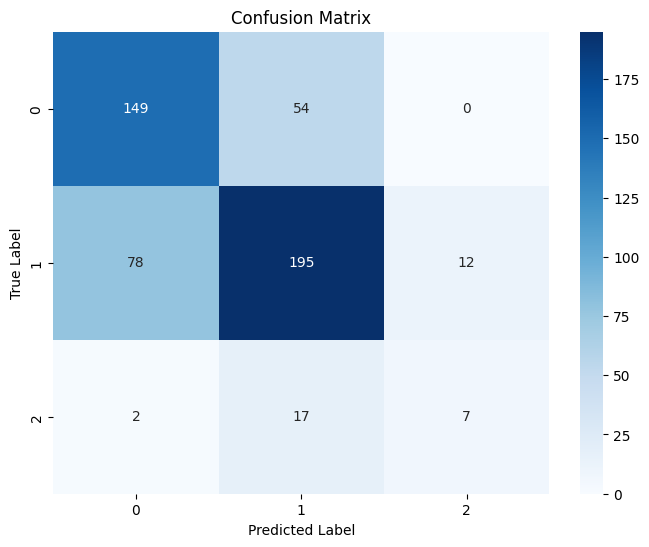

In [89]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()